## 2D Rectangular Basis

In [1]:
import sageresearch.utils.symbolic_vector_matrix as svm

In [149]:
# Mesh Coordinates
x = svm.get_vector_variable('x', 2)
# Canonical Coordinates
xi = svm.get_vector_variable('xi', 2)
# Mesh Vertices
v = svm.get_vector_variable('v', 4)
x_i = svm.get_matrix_variable('x_i', 2, 2)
delta_x = svm.get_vector_variable('\\Delta_x', 2)
dict_delta_x = {delta_x[0]: x_i[0, 1] - x_i[0, 0], delta_x[1]: x_i[1, 1] - x_i[1, 0]}
# v_0 = (x_0_0, x_1_0), v_1 = (x_0_1, x_1_0), v_2 = (x_0_1, x_1_1), v_3 = (x_0_0, x_1_1)
v_0_vec = vector([x_i[0, 0], x_i[1, 0]])
v_1_vec = vector([x_i[0, 1], x_i[1, 0]])
v_2_vec = vector([x_i[0, 1], x_i[1, 1]])
v_3_vec = vector([x_i[0, 0], x_i[1, 1]])
v_vec = [v_0_vec, v_1_vec, v_2_vec, v_3_vec]
dict_v_to_vec = {v[i]: v_vec[i] for i in range(4)}
dict_x_to_v = [{x[0]: v_vec[i][0], x[1]: v_vec[i][1]} for i in range(4)]
# mesh faces
dict_bottom_face_K = {x[1]: x_i[1, 0]}
dict_top_face_K = {x[1]: x_i[1, 1]}
dict_right_face_K = {x[0]: x_i[0, 1]}
dict_left_face_K = {x[0]: x_i[0, 0]}

# Canonical Vertices
u = svm.get_vector_variable('u', 4)
# u_0 = (-1, -1), u_1 = (1, -1), u_2 = (1, 1), u_3 = (-1, 1)
u_0_vec = vector([-1, -1])
u_1_vec = vector([1, -1])
u_2_vec = vector([1, 1])
u_3_vec = vector([-1, 1])
u_vec = [u_0_vec, u_1_vec, u_2_vec, u_3_vec]
dict_u_to_vec = {u[i]: u_vec[i] for i in range(4)}
dict_xi_to_u = [{xi[0]: u_vec[i][0], xi[1]: u_vec[i][1]} for i in range(4)]
# canonical faces
dict_bottom_face_mcK = {xi[1]: -1}
dict_top_face_mcK = {xi[1]: 1}
dict_right_face_mcK = {xi[0]: 1}
dict_left_face_mcK = {xi[0]: -1}
# outward facing normal vectors
n_bottom = vector([0, -1])
n_top = vector([0, 1])
n_right = vector([1, 0])
n_left = vector([-1, 0])

# transformation
# c(x): K -> mcK
# b(xi): mcK -> K
# elem centers
x_c = svm.get_vector_variable('x_c', 2)
dict_x_c = {x_c[0]: (x_i[0, 0] + x_i[0, 1]) / 2, x_c[1]: (x_i[1, 0] + x_i[1, 1]) / 2}
c_i = SR.symbol('c_i')
c_i_vec = vector([(x[0] - x_c[0]) * 2 / delta_x[0], (x[1] - x_c[1]) * 2 / delta_x[1]])
dict_c_i = {xi[0]: c_i_vec[0], xi[1]: c_i_vec[1]}
b_i = SR.symbol('b_i')
b_i_vec = vector([xi[0] * delta_x[0] / 2 + x_c[0], xi[1] * delta_x[1] / 2 + x_c[1]])
dict_b_i = {x[0]: b_i_vec[0], x[1]: b_i_vec[1]}

c_i_j = jacobian(c_i_vec, x)
b_i_j = jacobian(b_i_vec, xi)
# c_i_j b_i_j = I = b_i_j c_i_j
assert c_i_j * b_i_j == matrix.identity(2)
assert b_i_j * c_i_j == matrix.identity(2)

# Mesh Element Metric
m_i = b_i_j.det()

In [42]:
# Transformation by linear algebra solve
# c(x) = [c_0_0 x[0] + c_1_0 x[1] + c_2_0, c_0_1 x[0] + c_1_1 x[1] + c_2_1
# c(v[i]) = u[i]
c = svm.get_matrix_variable('c', 3, 2)
c_vec = vector([c[0, 0] * x[0] + c[1, 0] * x[1] + c[2, 0], c[0, 1] * x[0] + c[1, 1] * x[1] + c[2, 1]])
sol = solve(
    [c_vec[j].subs(dict_x_to_v[i]) == u_vec[i][j] for i in range(4) for j in range(2)], [c[i, j] for i in range(3) for j in range(2)], solution_dict=True
)
assert norm(c_vec.subs(sol[0]) - c_i_vec.subs(dict_x_c).subs(dict_delta_x)) == 0
# b(xi) = [b_0_0 xi[0] + b_1_0 xi[1] + b_2_0, b_0_1 xi[0] + b_1_1 xi[1] + b_2_1
# b(u[i]) = v[i]
b = svm.get_matrix_variable('b', 3, 2)
b_vec = vector([b[0, 0] * xi[0] + b[1, 0] * xi[1] + b[2, 0], b[0, 1] * xi[0] + b[1, 1] * xi[1] + b[2, 1]])
sol = solve(
    [b_vec[j].subs(dict_xi_to_u[i]) == v_vec[i][j] for i in range(4) for j in range(2)], [b[i, j] for i in range(3) for j in range(2)], solution_dict=True
)
assert norm(b_vec.subs(sol[0]) - b_i_vec.subs(dict_x_c).subs(dict_delta_x)) == 0

In [216]:
from sage.symbolic.integration.integral import definite_integral
# check integral transformations
# \dintt{K_i}{f(x)}{x} = \dintt{mcK}{f(b_i(xi)) m_i}{xi}
f = x[0]^2 + x[1]^2
mesh_integral = definite_integral(definite_integral(f, x[0], x_i[0, 0], x_i[0, 1]), x[1], x_i[1, 0], x_i[1, 1])
canonical_integral = definite_integral(definite_integral(f.subs(dict_b_i) * m_i, xi[0], -1, 1), xi[1], -1, 1).subs(dict_delta_x).subs(dict_x_c)
assert mesh_integral == canonical_integral

# \dintt{mcK}{f(xi)}{xi} = \dintt{K_i}{f(c_i(x)) / m_i}{x}
f = xi[0] * xi[1] + xi[1]^2
canonical_integral = definite_integral(definite_integral(f, xi[0], -1, 1), xi[1], -1, 1)
mesh_integral = definite_integral(definite_integral(
    f.subs(dict_c_i) / m_i, x[0], x_i[0, 0], x_i[0, 1]), x[1], x_i[1, 0], x_i[1, 1]).subs(dict_delta_x).subs(dict_x_c)
assert canonical_integral == mesh_integral

# \dintt{K_i}{f(x)_{x_0}}{x} = \dintt{mcK}{(f(b_i(xi))_{xi_0} * c_i[0]_{x_0} + f(b_i(xi))_{xi_1} c_i[1])m_i}{xi}
# \dintt{K_i}{f(x)_{x_0}}{x} = \dintt{mcK}{f(b_i(xi))_{xi_0} / b_i[0]_{x_0} m_i}{xi}
f = x[0]^2 + x[0] * x[1]
# d/dx_0 f(x) = d/dxi_0 f(b_i(xi)) * d/dx_0 c_i[0]
# d/dx_0 f(x) = d/dxi_0 f(b_i(xi)) / d/dxi_0 b_i[0]
mesh_integral = definite_integral(definite_integral(f.diff(x[0]), x[0], x_i[0, 0], x_i[0, 1]), x[1], x_i[1, 0], x_i[1, 1])
canonical_integral = definite_integral(definite_integral(
    f.subs(dict_b_i).diff(xi[0]) * c_i_j[0, 0] * m_i, xi[0], -1, 1), xi[1], -1, 1).subs(dict_delta_x).subs(dict_x_c)
assert mesh_integral == canonical_integral
canonical_integral = definite_integral(definite_integral(
    f.subs(dict_b_i).diff(xi[0]) / b_i_j[0, 0] * m_i, xi[0], -1, 1), xi[1], -1, 1).subs(dict_delta_x).subs(dict_x_c)
assert mesh_integral == canonical_integral
# \dintt{K_i}{f(x)_{x_1}}{x} = \dintt{mcK}{f(b_i(xi))_{xi_1} * c_i[1]_{x_1} m_i}{xi}
# \dintt{K_i}{f(x)_{x_1}}{x} = \dintt{mcK}{f(b_i(xi))_{xi_1} / b_i[1]_{xi_1} m_i}{xi}
f = x[0] * x[1]^2 + x[1]
mesh_integral = definite_integral(definite_integral(f.diff(x[1]), x[0], x_i[0, 0], x_i[0, 1]), x[1], x_i[1, 0], x_i[1, 1])
canonical_integral = definite_integral(definite_integral(
    f.subs(dict_b_i).diff(xi[1]) * c_i_j[1, 1] * m_i, xi[0], -1, 1), xi[1], -1, 1).subs(dict_delta_x).subs(dict_x_c)
assert mesh_integral == canonical_integral
canonical_integral = definite_integral(definite_integral(
    f.subs(dict_b_i).diff(xi[1]) / b_i_j[1, 1] * m_i, xi[0], -1, 1), xi[1], -1, 1).subs(dict_delta_x).subs(dict_x_c)
assert mesh_integral == canonical_integral

In [209]:
# Line Integral
t = SR.symbol('t')
# mesh line = C_i = v_0 + t * (v_2 - v_0)
r_m = v_vec[0] + t * (v_vec[2] - v_vec[0])
# mesh line = C_i = v_0 + t * (v_1 - v_0)
#r_m = vector([x_i[0, 0] + t * (x_i[0, 1] - x_i[0, 0]), x_i[1, 0]])
dict_r_m = {x[0]: r_m[0], x[1]: r_m[1]}
# \dintt{C_i}{f(x)}{s} = \dintt{0}{1}{f(r(t)) \norm{r'(t)}}{t}
f = x[1] * x[0] + x[0]^2
mesh_integral = definite_integral(f.subs(dict_r_m) * r_m.diff(t).norm(), t, 0, 1)

# canonical line = C = u_0 + t * (u_2 - u_0) = [-1 + 2 t, -1 + 2 t]
r_c = vector([-1 + 2 * t, -1 + 2 * t])
# canonical line = C = u_0 + t * (u_1 - u_0) = [-1 + 2 t, -1 + 2 t]
# r_c = vector([-1 + 2 * t, -1])
dict_r_c = {xi[0]: r_c[0], xi[1]: r_c[1]}
# r_c = c_i(r_m)
# r_m = b_i(r_c)
assert r_c == c_i_vec.subs(dict_r_m).subs(dict_x_c).subs(dict_delta_x).simplify_full()
# \dintt{C_i}{f(x)}{s} = \dintt{0}{1}{f(b_i(r(t))) \norm{b_i'(r(t)) r'(t)}{t}
canonical_integral = definite_integral(
    f.subs(dict_b_i).subs(dict_r_c) * (b_i_j.subs(dict_r_c) * r_c.diff(t)).norm(), t, 0, 1
).subs(dict_x_c).subs(dict_delta_x)
assert mesh_integral == canonical_integral

In [217]:
# Surface Integral
# \dintt{\partial K_i}{f(x)}{s} = \dintt{a}{b}{f(r(t)) \norm{r'(t)}}{t}, r(t) parameterization of \partial K_i
# for bottom face r(t) = [t, x_i_1_0],  a = x_i[0, 0], b = x_i[0, 1], norm(r'(t)) = 1, etc for all faces
f = x[0]^3 + x[1]^2
mesh_bottom_face_integral = definite_integral(f.subs(dict_bottom_face_K), x[0], x_i[0, 0], x_i[0, 1])
mesh_right_face_integral = definite_integral(f.subs(dict_right_face_K), x[1], x_i[1, 0], x_i[1, 1])
mesh_top_face_integral = definite_integral(f.subs(dict_top_face_K), x[0], x_i[0, 0], x_i[0, 1])
mesh_left_face_integral = definite_integral(f.subs(dict_left_face_K), x[1], x_i[1, 0], x_i[1, 1])
mesh_integral = mesh_bottom_face_integral + mesh_right_face_integral + mesh_top_face_integral + mesh_left_face_integral

# \dintt{\partial K_i}{f(x)}{s} = \dintt{a}{b}{f(b_i(r(t))) \norm{b_i'(r(t)) r'(t)}}{t}
# for bottom face r(t) = [t, -1], a = -1, b = 1, r'(t) = [1, 0], b_i' is constant, \norm(b_i'(r(t) r'(t))) = b_i_j[0, 0]
canonical_bottom_face_integral = definite_integral(
    f.subs(dict_b_i).subs(dict_bottom_face_mcK) * b_i_j[0, 0], xi[0], -1, 1
).subs(dict_delta_x).subs(dict_x_c)
canonical_right_face_integral = definite_integral(
    f.subs(dict_b_i).subs(dict_right_face_mcK) * b_i_j[1, 1], xi[1], -1, 1
).subs(dict_delta_x).subs(dict_x_c)
canonical_top_face_integral = definite_integral(
    f.subs(dict_b_i).subs(dict_top_face_mcK) * b_i_j[0, 0], xi[0], -1, 1
).subs(dict_delta_x).subs(dict_x_c)
canonical_left_face_integral = definite_integral(
    f.subs(dict_b_i).subs(dict_left_face_mcK) * b_i_j[1, 1], xi[1], -1, 1
).subs(dict_delta_x).subs(dict_x_c)
canonical_integral = canonical_bottom_face_integral + canonical_right_face_integral + canonical_top_face_integral + canonical_left_face_integral
assert mesh_integral == canonical_integral

In [76]:
f = x[0]^2 + x[0] * x[1]
print(f.diff(x[0]))
print((f.subs(dict_b_i).diff(xi[0]) * c_i_j[0, 0]).subs(dict_c_i).full_simplify())
print((f.subs(dict_b_i).diff(xi[0]) / b_i_j[0, 0]).subs(dict_c_i).full_simplify())

2*x_0 + x_1
2*x_0 + x_1
2*x_0 + x_1


In [120]:
# Integration by Parts Verification
# \dintt{K_i}{\div{f} \phi}{x} = \dintt{\partial K_i}{n . f \phi}{s} - \dintt{K_i}{f . \grad{\phi}}{x}
f = vector([x[0], x[1]])
phi = x[0]
lhs = definite_integral(definite_integral(f.div(x) * phi, x[0], x_i[0, 0], x_i[0, 1]), x[1], x_i[1, 0], x_i[1, 1])
bottom_face_integral = definite_integral((n_bottom * f * phi).subs(dict_bottom_face_K), x[0], x_i[0, 0], x_i[0, 1])
right_face_integral = definite_integral((n_right * f * phi).subs(dict_right_face_K), x[1], x_i[1, 0], x_i[1, 1])
top_face_integral = definite_integral((n_top * f * phi).subs(dict_top_face_K), x[0], x_i[0, 1], x_i[0, 0])
left_face_integral = definite_integral((n_left * f * phi).subs(dict_left_face_K), x[1], x_i[1, 1], x_i[1, 0])
rhs_surface_integral = bottom_face_integral + right_face_integral - top_face_integral - left_face_integral
rhs_area_integral = definite_integral(definite_integral(f * phi.gradient(x), x[0], x_i[0, 0], x_i[0, 1]), x[1], x_i[1, 0], x_i[1, 1])
rhs = rhs_surface_integral - rhs_area_integral
assert lhs == rhs

# Canonical Element
# \dintt{K_i}{\div_x{f(x)} \phi_i(x)}{x} = \dintt{K_i}{(f(x)_{x_0} + f(x)_{x_1}) \phi_i(x)}{x} 
#   = \dintt{mcK}{(f(b_i(xi))_{\xi_0} / b_i[0]_{xi_0} + f(b_i(xi))_{xi_1} / b_i[1]_{xi_1}) phi(xi) m_i}{xi}
# \dintt{\partial K_i}{n . f \phi}{s} - \dintt{K_i}{f(x) . \grad_x{\phi_i(x)}}{x} = \dintt{\partial mcK}{n}{xi} - \dintt{mcK}{f}
# \dintt{K_i}{f(x) . \grad_x{\phi_i(x)}}{x} = \dintt{K_i}{f_0(x) \phi_i(x)_{x_0} + f_1(x) \phi_i(x)_{x_1}}{x}
# = \dintt{mcK}{(f_0(b_i(xi)) \phi(xi)_{xi_0} / b_i[0]_{xi_0} + f_1(b_i(xi)) \phi(xi)_{xi_1} / b_i[1]_{xi_0}) m_i}{xi}
# \dintt{\partial mcK}{n . f(xi) \phi(xi)}{s} - \dintt{mcK}{f(xi) . \grad{\phi}}{xi}

canonical_rhs_area_integral = definite_integral(definite_integral(f))

In [160]:
bottom_face_integral = definite_integral((n_bottom * f * phi).subs(dict_bottom_face_K), x[0], x_i[0, 0], x_i[0, 1])
right_face_integral = definite_integral((n_right * f * phi).subs(dict_right_face_K), x[1], x_i[1, 0], x_i[1, 1])
top_face_integral = definite_integral((n_top * f * phi).subs(dict_top_face_K), x[0], x_i[0, 1], x_i[0, 0])
left_face_integral = definite_integral((n_left * f * phi).subs(dict_left_face_K), x[1], x_i[1, 1], x_i[1, 0])
rhs_surface_integral = bottom_face_integral + right_face_integral - top_face_integral - left_face_integral
rhs_area_integral = definite_integral(definite_integral(f * phi.gradient(x), x[0], x_i[0, 0], x_i[0, 1]), x[1], x_i[1, 0], x_i[1, 1])
rhs = rhs_surface_integral - rhs_area_integral

In [161]:
# mutlidimensional chain rule

0

In [159]:
rhs_area_integral

1/2*(x_i_0_0^2 - x_i_0_1^2)*(x_i_1_0 - x_i_1_1)

## 2D Triangular Basis from Hesthaven

In [2]:
import sageresearch.utils.symbolic_vector_matrix as svm

In [3]:
# polynomial order of basis
N = SR.symbol('N')
# number of points N_p
N_p = (N + 1) * (N + 2) / 2

In [4]:
N_p

1/2*(N + 2)*(N + 1)

In [158]:
v = svm.get_vector_variable('v', 4)
x = svm.get_vector_variable('x', 3)
xi = svm.get_vector_variable('xi', 3)
lambda_ = svm.get_vector_variable('lambda', 4)

# transformation to barycentric coordinate in canonical element
# xi^* = lambda^1 [-1, -1] + lamdba^2 [1, -1] + lambda^3 [-1, 1]
# 1 = lamdba^1 + lambda^2 + lambda^3
xi_star = svm.get_vector_variable('xi_star', 3)
mat_xi = matrix([[-1, 1, -1], [-1, -1, 1], [1, 1, 1]])
vec_xi = vector([xi_star[1], xi_star[2], 1])
lambda_from_canonical = mat_xi.inverse() * vec_xi

# transformation to barycentric coordinates in mesh element
# x^* = lambda^1 v^1 + lambda^2 v^2 + lambda^3 v^3
# 1 = lambda^1 + lambda^2 + lambda^3
x_star = svm.get_vector_variable('x_star', 3)
x_1 = svm.get_vector_variable('x_1', 4)
x_2 = svm.get_vector_variable('x_2', 4)
mat_x = matrix([[x_1[1], x_1[2], x_1[3]], [x_2[1], x_2[2], x_2[3]], [1, 1, 1]])
vec_x = vector([x_star[1], x_star[2], 1])

tmp = mat_x * lambda_from_canonical
x_star_1 = tmp[0]
x_star_2 = tmp[1]

# transformation from canonical to mesh
# b_i(xi) = 1/2 (v^2 - v^1) xi_1 + 1/2 (v^3 - v^1) xi_2 + 1/2 (v^2 + v^3)
b_i = vector([1/2 * (x_1[2] - x_1[1]) * xi[1] + 1/2 * (x_1[3] - x_1[1]) * xi[2] + 1/2 * (x_1[2] + x_1[3]),
             1/2 * (x_2[2] - x_2[1]) * xi[1] + 1/2 * (x_2[3] - x_2[1]) * xi[2] + 1/2 * (x_2[2] + x_2[3])])
b_i_j = jacobian(b_i, [xi[1], xi[2]])
J = b_i_j.det()

xi_1_x_1 = b_i_j[1, 1] / J
xi_1_x_2 = -b_i_j[0, 1] / J
xi_2_x_1 = -b_i_j[1, 0] / J
xi_2_x_2 = b_i_j[0, 0] / J
c_i = vector([xi_1_x_1 * x[1] + xi_1_x_2 * x[2], xi_2_x_1 * x[1] + xi_2_x_2 * x[2]])

lambda_from_mesh = mat_x.inverse() * vec_x
tmp = mat_xi * lambda_from_mesh

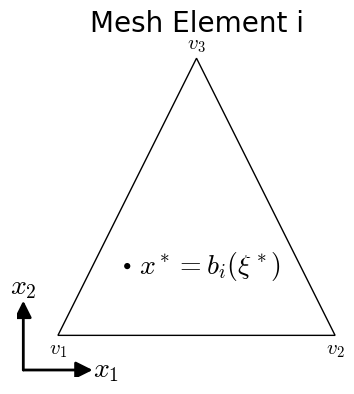

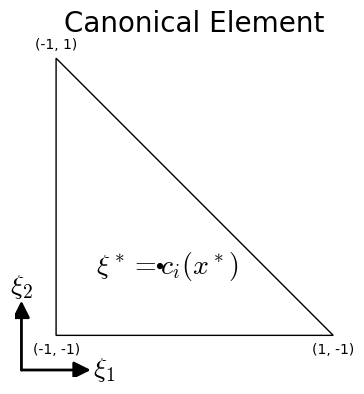

(-1/2, -1/2)
(-1/4, -1/2)


In [160]:
v1 = vector([-1, -1])
v2 = vector([1, -1])
v3 = vector([0, 1])
subs_v = {x_1[1]: v1[0], x_1[2]: v2[0], x_1[3]: v3[0], x_2[1]: v1[1], x_2[2]: v2[1], x_2[3]: v3[1]}
dy = vector([0, 0.1])
xi_star_1 = vector([-3/4, -1/2])
subs_xi_star = {xi[1]: xi_star_1[0], xi[2]: xi_star_1[1]}
x_star_1 = b_i.subs(subs_v).subs(subs_xi_star)
subs_x_star = {x[1]: x_star_1[0], x[2]: x_star_1[1]}
xi_star_2 = c_i.subs(subs_v).subs(subs_x_star)
D = polygon([v1, v2, v3], fill=False, color='black', axes=False)
axes = (arrow((-1.25, -1.25), (-1.25, -0.75), color='black') + 
    arrow((-1.25, -1.25), (-0.75, -1.25), color='black'))
text_D = (text("$x_1$", (-0.65, -1.25), color='black', fontsize=20)
          + text("$x_2$", (-1.25, -0.65), color='black', fontsize=20)
          + text('Mesh Element i', (0, 1.25), color='black', fontsize=20)
          + text('$v_1$', v1 - dy, color='black', fontsize=15)
          + text('$v_2$', v2 - dy, color='black', fontsize=15)
          + text('$v_3$', v3 + dy, color='black', fontsize=15)
          + point(x_star_1, color='black', size=20)
          + text('$x^* = b_i(\\xi^*)$', x_star_1 + vector([6/10, 0]), color='black', fontsize=20))
I = polygon([[-1, -1],[1, -1], [-1, 1]], fill=False, color='black', axes=False)
text_I = (text('$\\xi_1$', (-0.65, -1.25), color='black', fontsize=20)
          + text('$\\xi_2$', (-1.25, -0.65), color='black', fontsize=20)
          + text('Canonical Element', (0, 1.25), color='black', fontsize=20)
          + text('(-1, -1)', (-1, -1.1), color='black')
          + text('(1, -1)', (1, -1.1), color='black')
          + text('(-1, 1)', (-1, 1.1), color='black')
          + text('$\\xi^* = c_i(x^*)$', (-0.2, -0.5), color='black', fontsize=20)
          + point(xi_star_2, color='black', size=20))
show(axes + D + text_D)
show(axes + I + text_I)
print(x_star_1)
print(xi_star_2)

In [156]:
xi_1_x_1 * x_star[0]

2*(x_2_1 - x_2_3)*x_star_0/((x_1_1 - x_1_3)*(x_2_1 - x_2_2) - (x_1_1 - x_1_2)*(x_2_1 - x_2_3))

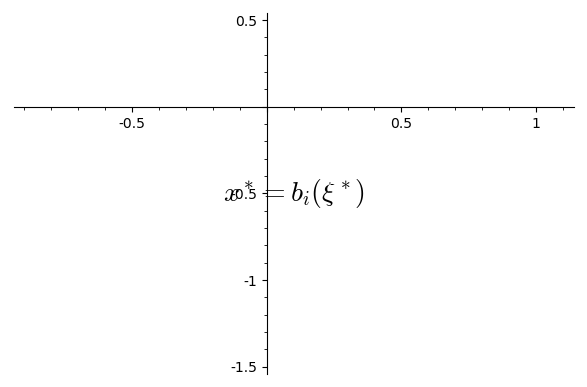

In [150]:
text('$x^* = b_i(\\xi^*)$', x_star_1 + vector([6/10, 0]), color='black', fontsize=20)

In [163]:
tmp[0].simplify_full()

-((x_1_2 + x_1_3)*x_2_1 - (x_1_1 - x_1_3)*x_2_2 - (x_1_1 + x_1_2)*x_2_3 - 2*(x_2_1 - x_2_3)*x_star_1 + 2*(x_1_1 - x_1_3)*x_star_2)/((x_1_2 - x_1_3)*x_2_1 - (x_1_1 - x_1_3)*x_2_2 + (x_1_1 - x_1_2)*x_2_3)

In [171]:
test = -((x_1[2] + x_1[3])*x_2[1] - (x_1[1] - x_1[3])*x_2[2] - (x_1[1] + x_1[2])*x_2[3])/((x_1[2] - x_1[3])*x_2[1] - (x_1[1] - x_1[3])*x_2[2] + (x_1[1] - x_1[2])*x_2[3])

In [172]:
test.simplify_full()

-((x_1_2 + x_1_3)*x_2_1 - (x_1_1 - x_1_3)*x_2_2 - (x_1_1 + x_1_2)*x_2_3)/((x_1_2 - x_1_3)*x_2_1 - (x_1_1 - x_1_3)*x_2_2 + (x_1_1 - x_1_2)*x_2_3)

In [168]:
J.simplify_full()

-1/4*(x_1_2 - x_1_3)*x_2_1 + 1/4*(x_1_1 - x_1_3)*x_2_2 - 1/4*(x_1_1 - x_1_2)*x_2_3

In [170]:
tmp[1].simplify_full()

((x_1_2 + x_1_3)*x_2_1 - (x_1_1 + x_1_3)*x_2_2 - (x_1_1 - x_1_2)*x_2_3 - 2*(x_2_1 - x_2_2)*x_star_1 + 2*(x_1_1 - x_1_2)*x_star_2)/((x_1_2 - x_1_3)*x_2_1 - (x_1_1 - x_1_3)*x_2_2 + (x_1_1 - x_1_2)*x_2_3)

In [4]:
a = svm.get_matrix_variable('a', 2, 3)
b = svm.get_matrix_variable('b', 2, 3)
x = svm.get_vector_variable('x', 2)
x0 = svm.get_vector_variable('x0', 3)
x0[2] = 1
x1 = svm.get_vector_variable('x1', 3)
x1[2] = 1
x2 = svm.get_vector_variable('x2', 3)
x2[2] = 1
xi = svm.get_vector_variable('xi', 2)
xi0 = vector([-1, 1, 1])
xi1 = vector([-1, -1, 1])
xi2 = vector([1, -1, 1])

In [12]:
(a * x1)[0]

a_0_0*x1_0 + a_0_1*x1_1 + a_0_2

In [10]:
sol = solve([(a * x0)[0]==-1, (a*x0)[1]==1, (a*x1)[0]==-1, (a*x1)[1]==-1, (a*x2)[0]==1, (a*x2)[1]==-1], 
      a[0, 0], a[0, 1], a[0, 2], a[1, 0], a[1, 1], a[1, 2])

In [6]:
solve([(b*xi0)[0]==x0[0], (b*xi0)[1]==x0[1], (b*xi1)[0]==x1[0], (b*xi1)[1]==x1[1], (b*xi2)[0]==x2[0], 
       (b*xi2)[1]==x2[1]], b[0, 0], b[0, 1], b[0, 2], b[1, 0], b[1, 1], b[1, 2])

[[b_0_0 == -1/2*x1_0 + 1/2*x2_0, b_0_1 == 1/2*x0_0 - 1/2*x1_0, b_0_2 == 1/2*x0_0 + 1/2*x2_0, b_1_0 == -1/2*x1_1 + 1/2*x2_1, b_1_1 == 1/2*x0_1 - 1/2*x1_1, b_1_2 == 1/2*x0_1 + 1/2*x2_1]]

# Orthogonal Modal Basis on Triangle

### Symbolic

In [5]:
xi = SR.symbol('xi')
eta = SR.symbol('eta')
def integrate_over_triangle(expression):
    return integral(integral(expression, xi, -1, -eta), eta, -1, 1)

def inner_product(u, v):
    return integrate_over_triangle(u * v) / 2

def project(u, v):
    return inner_product(u, v) * v

def gram_schmidt(v_list):
    e_list = []
    for v in v_list:
        u = v
        for e in e_list:
            u -= project(v, e)
        e = u / sqrt(inner_product(u, u))
        e_list.append(e)
    return e_list

In [33]:
e1 = 1
v2 = xi
u2 = v2 - project(v2, e1)
e2 = u2 / sqrt(inner_product(u2, u2))
v3 = eta
u3 = v3 - project(v3, e1) - project(v3, e2)
e3 = u3 / sqrt(inner_product(u3, u3))
v4 = xi^2
u4 = v4 - project(v4, e1) - project(v4, e2) - project(v4, e3)
e4 = u4 / sqrt(inner_product(u4, u4))
v5 = xi * eta
u5 = v5 - project()

In [6]:
v_list = [1, xi, eta, xi^2, xi * eta, eta^2, xi^3, xi^2 * eta, xi * eta^2, eta^3, xi^4, xi^3 * eta, xi^2 * eta^2, xi * eta^3, eta^4]
e_list = gram_schmidt(v_list)

In [7]:
e_list

[1,
 1/2*sqrt(2)*(3*xi + 1),
 3*sqrt(1/6)*(2*eta + xi + 1),
 3/2*sqrt(1/3)*(5*xi^2 + 2*xi - 1),
 3/4*sqrt(3)*sqrt(1/3)*(5*xi^2 + 2*xi - 1) + 9/4*sqrt(6)*sqrt(1/6)*(2*eta + xi + 1) + 15/2*eta*xi + 9/4*xi + 3/4,
 3/4*sqrt(1/15)*(sqrt(3)*sqrt(1/3)*(5*xi^2 + 2*xi - 1) + 15*sqrt(6)*sqrt(1/6)*(2*eta + xi + 1) + 30*eta^2 + 30*eta*xi + 3*xi - 9),
 35/4*xi^3 + 3/4*sqrt(3)*sqrt(1/3)*(5*xi^2 + 2*xi - 1) - 21/4*xi,
 3/20*sqrt(1/3)*(210*eta*xi^2 + 105*xi^3 + 39*sqrt(3)*sqrt(1/3)*(5*xi^2 + 2*xi - 1) + 5*sqrt(6)*sqrt(1/6)*(2*eta + xi + 1) + 180*eta*xi + 12*xi + 39),
 1/4*sqrt(1/5)*(210*eta^2*xi - 70*xi^3 + sqrt(3)*sqrt(1/3)*(210*eta*xi^2 + 105*xi^3 + 39*sqrt(3)*sqrt(1/3)*(5*xi^2 + 2*xi - 1) + 5*sqrt(6)*sqrt(1/6)*(2*eta + xi + 1) + 180*eta*xi + 12*xi + 39) + 5*sqrt(15)*sqrt(1/15)*(sqrt(3)*sqrt(1/3)*(5*xi^2 + 2*xi - 1) + 15*sqrt(6)*sqrt(1/6)*(2*eta + xi + 1) + 30*eta^2 + 30*eta*xi + 3*xi - 9) - 11*sqrt(3)*sqrt(1/3)*(5*xi^2 + 2*xi - 1) - 5*sqrt(6)*sqrt(1/6)*(2*eta + xi + 1) + 30*eta*xi - 33*xi - 11),
 1

In [8]:
m = [[e.expand().coefficient(v) for v in v_list[1:]] for e in e_list]

### Polynomial Ring

In [2]:
R.<xi, eta> = PolynomialRing(SR, order='negdeglex')

In [3]:
def integral_over_triangle(poly):
    xi_integral = poly.integral(xi)
    xi_definite_integral = xi_integral(-1, eta) - xi_integral(-eta, eta)
    eta_integral = xi_definite_integral.integral(eta)
    eta_definite_integral = eta_integral(xi, -1) - eta_integral(xi, 1)
    return eta_definite_integral

def inner_product(u, v):
    return integral_over_triangle(u * v) / 2

def project(u, v):
    return inner_product(u, v) * v

def gram_schmidt(v_list):
    e_list = []
    for v in v_list:
        u = v
        for e in e_list:
            u -= project(v, e)
        e = u / sqrt(inner_product(u, u))
        e_list.append(e)
    return e_list

In [4]:
max_degree = 4
v_list = [R(1), xi, eta, xi^2, xi * eta, eta^2, xi^3, xi^2 * eta, xi * eta^2, eta^3, xi^4, xi^3 * eta, xi^2 * eta^2, xi * eta^3, eta^4]
e_list = gram_schmidt(v_list)

In [4]:
e_list

[1,
 1/2*sqrt(2) + 3/2*sqrt(2)*xi,
 3*sqrt(1/6) + 3*sqrt(1/6)*xi + 6*sqrt(1/6)*eta,
 -3/2*sqrt(1/3) + 3*sqrt(1/3)*xi + 15/2*sqrt(1/3)*xi^2,
 9/4 + 6*xi + 9/2*eta + 15/4*xi^2 + 15/2*xi*eta,
 15/4*sqrt(1/15) + 15*sqrt(1/15)*xi + 45/2*sqrt(1/15)*eta + 15/4*sqrt(1/15)*xi^2 + 45/2*sqrt(1/15)*xi*eta + 45/2*sqrt(1/15)*eta^2,
 -3/4 + (-15/4)*xi + 15/4*xi^2 + 35/4*xi^3,
 3/4*sqrt(1/3) + 57/4*sqrt(1/3)*xi + 3/2*sqrt(1/3)*eta + 117/4*sqrt(1/3)*xi^2 + 27*sqrt(1/3)*xi*eta + 63/4*sqrt(1/3)*xi^3 + 63/2*sqrt(1/3)*xi^2*eta,
 25/4*sqrt(1/5) + 135/4*sqrt(1/5)*xi + 75/2*sqrt(1/5)*eta + 165/4*sqrt(1/5)*xi^2 + 90*sqrt(1/5)*xi*eta + 75/2*sqrt(1/5)*eta^2 + 35/4*sqrt(1/5)*xi^3 + 105/2*sqrt(1/5)*xi^2*eta + 105/2*sqrt(1/5)*xi*eta^2,
 7/4*sqrt(1/7) + 63/4*sqrt(1/7)*xi + 21*sqrt(1/7)*eta + 63/4*sqrt(1/7)*xi^2 + 63*sqrt(1/7)*xi*eta + 105/2*sqrt(1/7)*eta^2 + 7/4*sqrt(1/7)*xi^3 + 21*sqrt(1/7)*xi^2*eta + 105/2*sqrt(1/7)*xi*eta^2 + 35*sqrt(1/7)*eta^3,
 15/8*sqrt(1/5) + (-15/2*sqrt(1/5))*xi + (-105/4*sqrt(1/5))*xi^2 + 3

In [5]:
m = []
for poly in e_list:
    coefficients = []
    for degree in range(max_degree + 1):
        for eta_degree in range(degree + 1):
            xi_degree = degree - eta_degree
            coefficients.append(poly.coefficient({xi: xi_degree, eta: eta_degree}))
    m.append(coefficients)

In [6]:
m

[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1/2*sqrt(2), 3/2*sqrt(2), 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [3*sqrt(1/6), 3*sqrt(1/6), 6*sqrt(1/6), 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [-3/2*sqrt(1/3),
  3*sqrt(1/3),
  0,
  15/2*sqrt(1/3),
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [9/4, 6, 9/2, 15/4, 15/2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [15/4*sqrt(1/15),
  15*sqrt(1/15),
  45/2*sqrt(1/15),
  15/4*sqrt(1/15),
  45/2*sqrt(1/15),
  45/2*sqrt(1/15),
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [-3/4, -15/4, 0, 15/4, 0, 0, 35/4, 0, 0, 0, 0, 0, 0, 0, 0],
 [3/4*sqrt(1/3),
  57/4*sqrt(1/3),
  3/2*sqrt(1/3),
  117/4*sqrt(1/3),
  27*sqrt(1/3),
  0,
  63/4*sqrt(1/3),
  63/2*sqrt(1/3),
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [25/4*sqrt(1/5),
  135/4*sqrt(1/5),
  75/2*sqrt(1/5),
  165/4*sqrt(1/5),
  90*sqrt(1/5),
  75/2*sqrt(1/5),
  35/4*sqrt(1/5),
  105/2*sqrt(1/5),
  105/2*sqrt(1/5),
  0,
  0,
  0,
  0,
  0,
  0],
 [7/4*sqrt(1/7),
  63/4*sqrt(1/7),
  21*sqrt(1/7),
  63/4*

In [17]:
mass_matrix = [[inner_product(e1, e2) for e1 in e_list] for e2 in e_list]

In [18]:
mass_matrix

[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]

In [8]:
[float(x) for x in m[13]]

[2.588284905106082,
 26.62235902394827,
 31.05941886127298,
 53.24471804789654,
 133.11179511974134,
 77.64854715318245,
 32.53843880704789,
 150.8600344690402,
 177.48239349298848,
 51.76569810212164,
 3.327794877993534,
 39.9335385359224,
 99.83384633980602,
 66.55589755987067,
 0.0]

In [9]:
[float(x) for x in m[14]]

[0.41926274578121053,
 6.7082039324993685,
 8.38525491562421,
 15.09345884812358,
 50.31152949374527,
 37.73364712030895,
 6.7082039324993685,
 50.31152949374527,
 100.62305898749054,
 58.69678440936948,
 0.41926274578121053,
 8.38525491562421,
 37.73364712030895,
 58.69678440936948,
 29.34839220468474]

In [ ]:
    {1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0},
    {0.0, 3.0*sq2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0},
    {0.0, sq2*sq3, 2.0*sq2*sq3, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0},
    {(5.0/21.0)*sq7, 8.0/sq7, 8.0/sq7, 60.0/sq7, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0},
    {-10.0/9.0*(sq3/sq7), -2.0/(sq3*sq7), 4.0*sq3/sq7, 30.0*sq3/sq7, 5.0*sq3*sq7, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0},
    {-2.0/9.0*sq3*sq5, 2.0*sq5/sq3, 0, 6.0*sq3*sq5, sq3*sq5, 6.0*sq3*sq5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0},
    {-8.0*sq3*sq13/117.0, 20.0/(sq3*sq13), -20.0/(sq3*sq13), 20.0*sq3/sq13, 40.0*sq3/sq13, 0, 210.0*sq3/sq13, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0},
    {-8.0/351.0*sq3*sq5*sq13*sq19, -4.0/247.0*sq3*sq5*sq13*sq19, 4.0/247.0*sq3*sq5*sq13*sq19, (20.0/39.0)*sq3*sq5*sq13*sq19, (344.0/741.0)*sq3*sq5*sq13*sq19, (32.0/57.0)*sq3*sq5*sq13*sq19, (602.0/247.0)*sq3*sq5*sq13*sq19, (56.0/19.0)*sq3*sq5*sq13*sq19, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0},
    {0.0, -52.0/(sq3*sq19), -(8.0/19.0)*sq3*sq19, (8.0/3.0)*sq3*sq19, -4.0/(sq3*sq19), 80.0/(sq3*sq19), (392.0/19.0)*sq3*sq19, (140.0/19.0)*sq3*sq19, 14.0*sq3*sq19, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0},
    {0.0, -(4.0/3.0)*sq7, -(8.0/3.0)*sq7, 8.0*sq7, 4.0*sq7, 0, 24.0*sq7, 60.0*sq7, 2.0*sq7, 40.0*sq7, 0.0, 0.0, 0.0, 0.0, 0.0},
    {-(2.0/27.0)*sq5*sq7, -(26.0/21.0)*sq5*sq7, -(4.0/21.0)*sq5*sq7, -6.0*sq5*sq7, sq5*sq7, 0, 0, 0, 16.0*sq5*sq7, 0, 72.0*sq5*sq7, 0.0, 0.0, 0.0, 0.0},
    {-(2.0/1053.0)*sq5*sq7*sq13*sq23, (314.0/6279.0)*sq5*sq7*sq13*sq23, -(544.0/6279.0)*sq5*sq7*sq13*sq23, -(2.0/13.0)*sq5*sq7*sq13*sq23, -(47.0/897.0)*sq5*sq7*sq13*sq23, (70.0/897.0)*sq5*sq7*sq13*sq23, 0.0, 0.0, -(752.0/897.0)*sq5*sq7*sq13*sq23, (1120.0/897.0)*sq5*sq7*sq13*sq23, -(1128.0/299.0)*sq5*sq7*sq13*sq23, (1680.0/299.0)*sq5*sq7*sq13*sq23, 0.0, 0.0, 0.0},
    {(55.0/74763.0)*sq7*sq13*sq71, -(440.0/2769.0)*sq7*sq13*sq71, -(440.0/2769.0)*sq7*sq13*sq71, -(140.0/923.0)*sq7*sq13*sq71, -(160.0/2769.0)*sq7*sq13*sq71, -(160.0/2769.0)*sq7*sq13*sq71, (360.0/71.0)*sq7*sq13*sq71, (360.0/71.0)*sq7*sq13*sq71, (6800.0/2769.0)*sq7*sq13*sq71, (6800.0/2769.0)*sq7*sq13*sq71, (10200.0/923.0)*sq7*sq13*sq71, (10200.0/923.0)*sq7*sq13*sq71, (1620.0/71.0)*sq7*sq13*sq71, 0.0, 0.0},
    {(2.0/639.0)*sq3*sq5*sq23*sq71, (4.0/14697.0)*sq3*sq5*sq23*sq71, -(280.0/14697.0)*sq3*sq5*sq23*sq71, -(20.0/71.0)*sq3*sq5*sq23*sq71, -(466.0/1633.0)*sq3*sq5*sq23*sq71, -(40.0/1633.0)*sq3*sq5*sq23*sq71, (60.0/71.0)*sq3*sq5*sq23*sq71, (60.0/sq71)*sq3*sq5*sq23, -(4.0/1633.0)*sq3*sq5*sq23*sq71, (280.0/1633.0)*sq3*sq5*sq23*sq71, (9780.0/1633.0)*sq3*sq5*sq23*sq71, (1260.0/1633.0)*sq3*sq5*sq23*sq71, (270.0/sq71)*sq3*sq5*sq23, 3.0*sq3*sq5*sq23*sq71, 0.0},
    {(2.0/9.0)*sq5, -(4.0/3.0)*sq5, 0.0, -20.0*sq5, -2.0*sq5, -20.0*sq5, 60.0*sq5, 60.0*sq5, 12.0*sq5, 0.0, 60.0*sq5, 420.0*sq5, 270.0*sq5, 3.0*sq5, 210.0*sq5}
